In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import optuna

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('./data/train.csv').set_index('id')
data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('rainfall', axis=1), data['rainfall'], 
                                                    stratify=data['rainfall'], random_state=42)

In [5]:
models = {
    'Logistic_Reg' : LogisticRegression(),
    'SVC' : LinearSVC(),
    'DT' : DecisionTreeClassifier(),
    'RF' : RandomForestClassifier(),
    'XGB': XGBClassifier(),
    'Cat' : CatBoostClassifier(verbose=0),
    'LGB': LGBMClassifier(verbose=0),
}

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, data.drop('rainfall', axis=1), data['rainfall'], cv=cv, scoring="roc_auc")
    cv_scores[name] = scores
    print(f"{name}: Mean ROC-AUC = {np.mean(scores):.4f}, Std Dev = {np.std(scores):.4f}")

print("\nDetailed Scores:")
for name, scores in cv_scores.items():
    print(f"{name}: {scores}")

Logistic_Reg: Mean ROC-AUC = 0.8942, Std Dev = 0.0213
SVC: Mean ROC-AUC = 0.8916, Std Dev = 0.0216
DT: Mean ROC-AUC = 0.7220, Std Dev = 0.0127
RF: Mean ROC-AUC = 0.8795, Std Dev = 0.0236
XGB: Mean ROC-AUC = 0.8705, Std Dev = 0.0235
Cat: Mean ROC-AUC = 0.8882, Std Dev = 0.0252
LGB: Mean ROC-AUC = 0.8752, Std Dev = 0.0281

Detailed Scores:
Logistic_Reg: [0.9209596  0.86088664 0.88162177 0.91060606 0.89708193]
SVC: [0.91885522 0.86136364 0.87382155 0.91046577 0.8934624 ]
DT: [0.73442761 0.71262626 0.70378788 0.73728956 0.721633  ]
RF: [0.91875701 0.85035073 0.86313131 0.89029181 0.87519641]
XGB: [0.90945567 0.83964646 0.85531706 0.87864759 0.86930415]
Cat: [0.92084736 0.85238496 0.86652637 0.90510662 0.89604377]
LGB: [0.91099888 0.84391134 0.84034792 0.8907688  0.89015152]


In [10]:
# Define parameter grid for Logistic Regression
param_grid = {
    "penalty": ["l1", "l2", "elasticnet", None],  # Regularization type
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
    "solver": ["liblinear", "saga"],  # Solvers that support l1 & l2
    "max_iter": [100, 500, 1000, 10000]  # Iteration limits
}


logreg = LogisticRegression()

grid_search = GridSearchCV(
    logreg, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_preds = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_preds)
print(f"Best Model ROC-AUC Score: {auc_score:.4f}")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best Parameters: {'C': 0.01, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
Best Model ROC-AUC Score: 0.8869


In [ ]:
pd.crosstab(y_test, y_preds)

col_0,0,1
rainfall,,
0,81,54
1,20,393


In [12]:
param_grid = {
    "n_estimators": [100, 200, 500],  # Number of trees
    "max_depth": [None, 10, 20, 30],  # Depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf
    "max_features": ["sqrt", "log2"],  # Number of features to consider at each split
    "bootstrap": [True, False]  # Bootstrapping method
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    rf, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=3
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_preds = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_preds)
print(f"Best Model ROC-AUC Score: {auc_score:.4f}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Model ROC-AUC Score: 0.8827


In [15]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }

    model = XGBClassifier(
        **params, tree_method="gpu_hist", random_state=42, use_label_encoder=False, eval_metric="auc"
    )

    model.fit(X_train, y_train)
    y_preds = model.predict_proba(X_test)[:, 1]

    # Calculate ROC-AUC score
    return roc_auc_score(y_test, y_preds)

In [16]:
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=200, show_progress_bar=True)  

print("Best Parameters:", study.best_params)

print(f"Best ROC-AUC Score: {study.best_value:.4f}")

[I 2025-03-01 07:53:13,224] A new study created in memory with name: no-name-2c257f35-aa7e-41e0-a704-b6d6f73a0870


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-03-01 07:53:13,739] Trial 0 finished with value: 0.8781275221953188 and parameters: {'n_estimators': 400, 'learning_rate': 0.17831329457867465, 'max_depth': 4, 'subsample': 0.5236745084083234, 'colsample_bytree': 0.7057096126085339, 'gamma': 2.7504380571290614, 'reg_lambda': 0.002490410925254068, 'reg_alpha': 0.12037383377415854, 'min_child_weight': 6}. Best is trial 0 with value: 0.8781275221953188.
[I 2025-03-01 07:53:14,482] Trial 1 finished with value: 0.8559770424177202 and parameters: {'n_estimators': 900, 'learning_rate': 0.19632900677191079, 'max_depth': 3, 'subsample': 0.6867280891704155, 'colsample_bytree': 0.661978721073455, 'gamma': 0.9067044060737794, 'reg_lambda': 0.0647462845403956, 'reg_alpha': 0.10298331142279517, 'min_child_weight': 7}. Best is trial 0 with value: 0.8781275221953188.
[I 2025-03-01 07:53:14,999] Trial 2 finished with value: 0.8839745314321585 and parameters: {'n_estimators': 300, 'learning_rate': 0.022730403413541312, 'max_depth': 6, 'subsample

In [33]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 3, 12),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-3, 10),
        "border_count": trial.suggest_int("border_count", 32, 64),
    }

    model = CatBoostClassifier(**params, loss_function="Logloss", eval_metric="AUC", 
                               random_seed=42, verbose=0, gpu_ram_part=0.9)

    model.fit(X_train, y_train)

    y_preds = model.predict_proba(X_test)[:, 1]  

    return roc_auc_score(y_test, y_preds)

study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=200, show_progress_bar=True) 

print("Best Parameters:", study.best_params)
print(f"Best ROC-AUC Score: {study.best_value:.4f}")

[I 2025-03-01 08:10:53,118] A new study created in memory with name: no-name-0ae981b5-3864-4120-8e6e-71f780ec235d


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-03-01 08:10:54,981] Trial 0 finished with value: 0.8709174065106268 and parameters: {'iterations': 200, 'learning_rate': 0.08979805036097739, 'depth': 12, 'l2_leaf_reg': 0.12969630522290115, 'border_count': 35}. Best is trial 0 with value: 0.8709174065106268.
[I 2025-03-01 08:10:55,175] Trial 1 finished with value: 0.8836337548201956 and parameters: {'iterations': 200, 'learning_rate': 0.020599177079098845, 'depth': 4, 'l2_leaf_reg': 3.8873798056092554, 'border_count': 52}. Best is trial 1 with value: 0.8836337548201956.
[I 2025-03-01 08:10:55,787] Trial 2 finished with value: 0.8815711595372613 and parameters: {'iterations': 700, 'learning_rate': 0.0101578498950692, 'depth': 5, 'l2_leaf_reg': 0.5105869986161461, 'border_count': 56}. Best is trial 1 with value: 0.8836337548201956.
[I 2025-03-01 08:10:56,523] Trial 3 finished with value: 0.858703255313425 and parameters: {'iterations': 800, 'learning_rate': 0.060698618530657125, 'depth': 6, 'l2_leaf_reg': 0.008266913469476776, '

In [18]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 10, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
    }

    model = LGBMClassifier(**params, verbose=-1)  
    model.fit(X_train, y_train)
    
    y_preds = model.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, y_preds)

study = optuna.create_study(direction="maximize",)
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("Best Params:", study.best_params)

[I 2025-03-01 08:44:39,091] A new study created in memory with name: no-name-fac096de-0231-43e5-82ef-a73368da1444


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-03-01 08:44:39,132] Trial 0 finished with value: 0.8821899381221415 and parameters: {'max_depth': 11, 'num_leaves': 130, 'learning_rate': 0.0019564718136403387, 'feature_fraction': 0.48559261685488536, 'bagging_fraction': 0.577808159193703, 'bagging_freq': 4, 'min_child_samples': 19, 'lambda_l1': 1.1985096039231887e-05, 'lambda_l2': 0.06341187034699722, 'min_gain_to_split': 12.92579330707239}. Best is trial 0 with value: 0.8821899381221415.
[I 2025-03-01 08:44:39,163] Trial 1 finished with value: 0.8790243027531163 and parameters: {'max_depth': 10, 'num_leaves': 13, 'learning_rate': 0.003727734541788802, 'feature_fraction': 0.581424369445939, 'bagging_fraction': 0.531029105450197, 'bagging_freq': 5, 'min_child_samples': 21, 'lambda_l1': 4.434874902874757, 'lambda_l2': 3.546531548011802e-06, 'min_gain_to_split': 1.3596890924197673}. Best is trial 0 with value: 0.8821899381221415.
[I 2025-03-01 08:44:39,183] Trial 2 finished with value: 0.8814097390368576 and parameters: {'max_de

In [13]:
params = {'n_estimators': 100, 'learning_rate': 0.011837960035904234, 'max_depth': 7, 
          'subsample': 0.9785357397543103, 'colsample_bytree': 0.5169932530689381, 
          'gamma': 1.2107155821958564, 'reg_lambda': 1.1502624318942887, 'reg_alpha': 0.24740691119158026, 
          'min_child_weight': 2}

model1 = XGBClassifier(**params, verbose=0, tree_method="gpu_hist")
model1.fit(X_train, y_train)
y_probs = model1.predict_proba(X_test)[:, 1]

print(f'ROC AUC Score": {roc_auc_score(y_test, y_probs)}')

ROC AUC Score": 0.895309837682719


In [14]:
test = pd.read_csv('./data/test.csv').set_index('id')
preds = model.predict_proba(test)[:, 1]

submission = pd.read_csv('./data/sample_submission.csv')
submission['rainfall'] = preds

submission.to_csv('./submission/XGBoost_200_optuna.csv', index=False)

In [15]:
params = {'iterations': 100, 'learning_rate': 0.07790350384975935, 
          'depth': 8, 'l2_leaf_reg': 5.429392445902465, 'border_count': 38}


model2 = CatBoostClassifier(**params, verbose=0)
model2.fit(X_train, y_train)
y_probs = model2.predict_proba(X_test)[:, 1]

print(f'ROC AUC Score": {roc_auc_score(y_test, y_probs)}')

ROC AUC Score": 0.8878486234418438


In [23]:
params = {'max_depth': 11, 'num_leaves': 139, 'learning_rate': 0.1394552398987031,
        'feature_fraction': 0.7205159877181965, 'bagging_fraction': 0.9965149953761379, 
        'bagging_freq': 3, 'min_child_samples': 92, 'lambda_l1': 1.4313376954414664e-08, 
        'lambda_l2': 6.390062038048195, 'min_gain_to_split': 0.5655566115584013}
model3 = LGBMClassifier(**params, verbose=-1)
model3.fit(X_train, y_train)
y_probs = model3.predict_proba(X_test)[:, 1]

print(f'ROC AUC Score": {roc_auc_score(y_test, y_probs)}')

ROC AUC Score": 0.8997758048605506


In [25]:
params= {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 
         'min_samples_split': 10, 'n_estimators': 100}
model4 = RandomForestClassifier(**params)
model4.fit(X_train, y_train)
y_probs = model4.predict_proba(X_test)[:, 1]

print(f'ROC AUC Score": {roc_auc_score(y_test, y_probs)}')

ROC AUC Score": 0.8814635458703255


In [40]:
from sklearn.ensemble import StackingClassifier

meta_model = LogisticRegression()

stack_clf = StackingClassifier(
    estimators=[
        ("xgb", model1),  
        # ("cat", model2),  
        ("lgb", model3),
        ('rf', model4)
    ],
    final_estimator=meta_model,
    cv=5,
    passthrough=True 
)

stack_clf.fit(X_train, y_train)

y_preds = stack_clf.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_preds)
print(f"Stacking Classifier AUC: {auc_score:.4f}")

Stacking Classifier AUC: 0.8871


In [41]:
stack_clf

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5169932530689381,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamma=1.2107155821958564,
                                              grow_policy=None,
                                              importance_type=None,
                                              inter...
                                               feature_fraction=0.7205159877181965,
                                               lambda_l1=1.4313376954414664e-08,
                                               lambda_l2=6.390062038048195,
                                               learning_rate=0.1394552398987031,
                                               max_depth=11,
                                               min_child_samples=92,
                                               min_gain_to_split=0.5655566115584013,
                                               num_leaves=139, verbose=-1)),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=4,
                                                       min_samples_split=10))],
                   final_estimator=LogisticRegression(), passthrough=True)

In [50]:
test['winddirection'].fillna(0, axis=0, inplace=True)

In [51]:
submission['rainfall'] = stack_clf.predict_proba(test)[:, 1]

submission.to_csv('./submission/Stacked_CLF.csv')

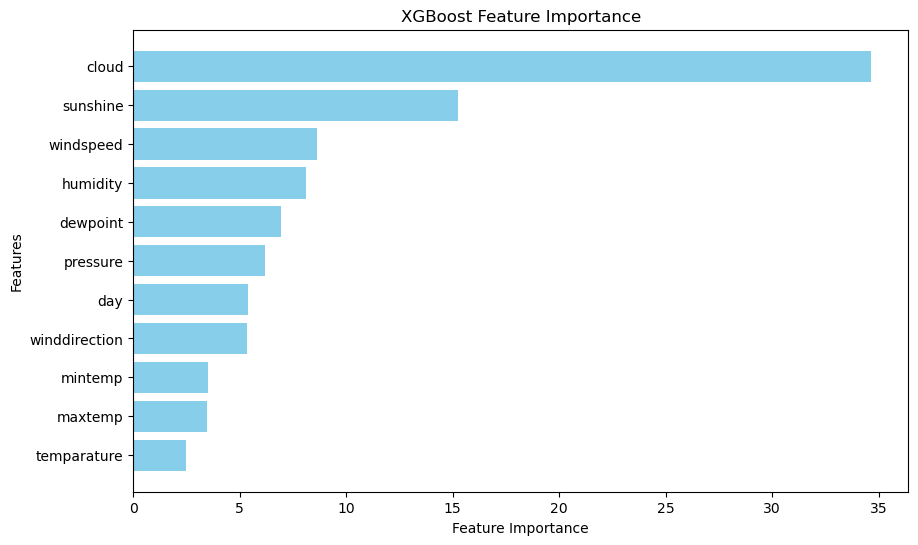

In [54]:
importances = model2.feature_importances_
columns = X_train.columns

# Sort features by importance (optional)
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(y=np.array(columns)[sorted_idx], width=importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

In [61]:
selected_cols = ['cloud', 'sunshine', 'windspeed', 'humidity', ]#'dewpoint', 'pressure','winddirection']
stack_clf.fit(X_train[selected_cols], y_train)

y_preds = stack_clf.predict_proba(X_test[selected_cols])[:, 1]

auc_score = roc_auc_score(y_test, y_preds)
print(f"Stacking Classifier AUC: {auc_score:.4f}")

Stacking Classifier AUC: 0.8850
